# MESSI Cluster Analysis

Robert Wright | r.wright@fu-berlin.de

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from IPython.display import display
sns.set_style("darkgrid")
#os.environ['CARTOPY_USER_BACKGROUNDS'] = "./bg"

## DATA IMPORT AND TIDYING

Es werden zunächst die Standortdaten der DWD-Messstationen und der MESSIs eingelesen.

In [2]:
# import location of dwd stations
dwd_loc = pd.read_csv("../data/stationen_berlin_brandenburg.txt", delim_whitespace=True)

dwd_loc = (dwd_loc
    .drop(["von_datum", "bis_datum", "Bundesland"], axis="columns")
    .rename(columns = {"Stationshoehe": "alt", "geoBreite": "lat", "geoLaenge": "lon", "Stationsname": "station_name", "Stations_id": "id"})
)
dwd_loc["origin"] = "dwd"
dwd_loc

,id,alt,lat,lon,station_name,origin
0,399,36,52.5198,13.4057,Berlin-Alexanderplatz,dwd
1,400,60,52.6310,13.5021,Berlin-Buch,dwd
2,410,33,52.4040,13.7309,Berlin-Kaniswall,dwd
3,420,61,52.5447,13.5598,Berlin-Marzahn,dwd
4,427,46,52.3807,13.5306,Berlin-Brandenburg,dwd
5,430,36,52.5644,13.3088,Berlin-Tegel,dwd
6,433,48,52.4675,13.4021,Berlin-Tempelhof,dwd


In [3]:
# import location & altitude of messis
messi_loc = pd.read_csv("../data/messi_standorte.csv")
messi_loc = messi_loc.rename(columns = {"gauge_id": "id"})
messi_loc["origin"] = "messi"
messi_loc.head()

,id,lon,lat,alt,origin
0,2,13.33395,52.48429,42,messi
1,8,13.47643,52.44803,34,messi
2,9,13.31014,52.45784,72,messi
3,13,13.55526,52.55220,52,messi
4,17,13.52497,52.45489,34,messi


Der _dataframe_ mit den Temperaturmessungen wird in das _tidy format_ gebracht und dann werden mithilfe der Stations-IDs die jeweiligen Standortdaten hinzugefügt.

In [4]:
# import temperature data and parse measurement time as datetime object
meas = pd.read_csv("../data/data.csv", parse_dates=["time_measured"])
meas = meas.melt(id_vars="time_measured", var_name="id", value_name="tmp")
meas['id'] = meas["id"].astype(int)
# focus on august (remove last value of 2022-09-01 00:00:00, which is technically december)
meas = meas[meas.time_measured.dt.month == 8]
meas.tail()


,time_measured,id,tmp
178594,2022-08-31 23:10:00,420,15.1
178595,2022-08-31 23:20:00,420,15.0
178596,2022-08-31 23:30:00,420,14.9
178597,2022-08-31 23:40:00,420,14.8
178598,2022-08-31 23:50:00,420,14.8


In [5]:
# https://stackoverflow.com/questions/54487745/how-to-merge-pandas-dataframes-without-duplicating-columns
tmp_raw = meas.merge(right=pd.concat([messi_loc, dwd_loc], axis="index"), how="left", on="id")
# add day column
tmp_raw["day"] = tmp_raw["time_measured"].dt.day
tmp_raw.head()

,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
0,2022-08-01 00:00:00,2,21.690,13.33395,52.48429,42.0,messi,NaN,1
1,2022-08-01 00:10:00,2,21.530,13.33395,52.48429,42.0,messi,NaN,1
2,2022-08-01 00:20:00,2,21.260,13.33395,52.48429,42.0,messi,NaN,1
3,2022-08-01 00:30:00,2,21.075,13.33395,52.48429,42.0,messi,NaN,1
4,2022-08-01 00:40:00,2,21.030,13.33395,52.48429,42.0,messi,NaN,1


## PRELIMINARY ANALYSIS

In [6]:
tmp_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178560 entries, 0 to 178559
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time_measured  178560 non-null  datetime64[ns]
 1   id             178560 non-null  int64         
 2   tmp            113759 non-null  float64       
 3   lon            160704 non-null  float64       
 4   lat            160704 non-null  float64       
 5   alt            160704 non-null  float64       
 6   origin         160704 non-null  object        
 7   station_name   17856 non-null   object        
 8   day            178560 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 13.6+ MB


Anscheinend gibt es ein paar IDs in `data.csv`, bei denen keine Temperaturwerte und Standortdaten vorliegen, daher die unterschiedliche Anzahl an Eintragungen in _id_ und den Spalten der Umgebungsvariablen.

In [7]:
# some messis do not have any (location) data
nmessi = tmp_raw["id"][tmp_raw.lat.isna()].drop_duplicates().values

for n in nmessi:
    id = tmp_raw[tmp_raw.id == n]
    print(f"# id = {n}\ndifferent tmp values:", id["tmp"].drop_duplicates().values)
    display(id[~id.tmp.isna()])

# remove these messis
tmp_raw = tmp_raw[~tmp_raw.id.isin(nmessi)]

# id = 15
different tmp values: [nan]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day


# id = 58
different tmp values: [    nan 26.5527]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
103786,2022-08-08 17:40:00,58,26.5527,NaN,NaN,NaN,NaN,NaN,8


# id = 76
different tmp values: [   nan 19.995 19.86 ]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
134355,2022-08-04 00:30:00,76,19.995,NaN,NaN,NaN,NaN,NaN,4
134357,2022-08-04 00:50:00,76,19.860,NaN,NaN,NaN,NaN,NaN,4


# id = 79
different tmp values: [    nan 25.7666]


,time_measured,id,tmp,lon,lat,alt,origin,station_name,day
138922,2022-08-04 17:40:00,79,25.7666,NaN,NaN,NaN,NaN,NaN,4


Das Fehlen der Temperaturwerte nehme ich zum Anlass, die Anzahl der *missing values* für jeden MESSI herauszufinden.

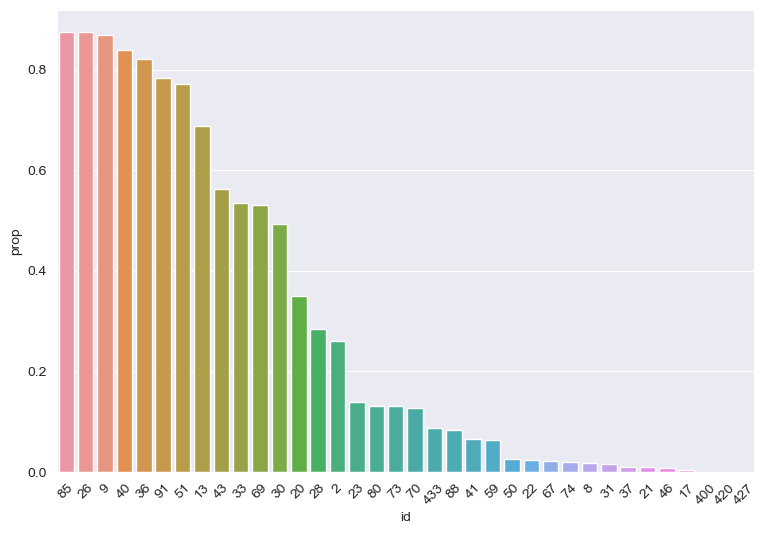

In [8]:
# number of nans per messi
# https://stackoverflow.com/questions/53947196/groupby-class-and-count-missing-values-in-features
nans = (tmp_raw
    .isna()
    .groupby(tmp_raw.id)[['tmp']]
    .sum()
    .sort_values(by="tmp", ascending=False)
    .reset_index()
)
# number of time steps per messi (highest possible number of nans)
nans["total"] = tmp_raw.groupby(["id"]).size().values[0]
# compute proportion of missing values
nans["prop"] = nans.tmp / nans.total
# convert to string for descending bar plot
nans["id"] = nans["id"].astype(str)

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=nans, x="id", y="prop", ax=ax)
ax.tick_params(axis="x", rotation=45)

Der Temperturverlauf der einzelnen Messpunkte wird dargestellt. Wie bereits erwähnt, fehlen bei einigen MESSIs Datenpunkte, deshalb sind "unschöne" Linien zu erkennen.

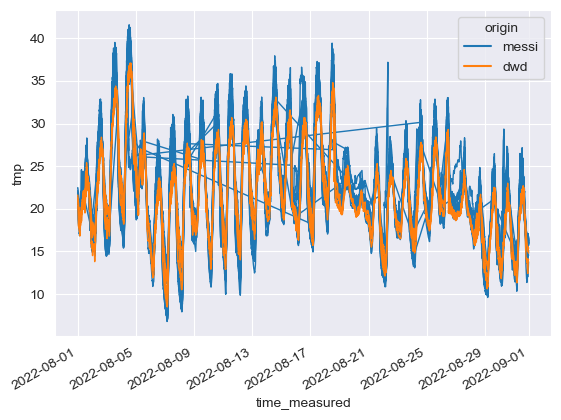

In [9]:
# temperature values
fig, ax = plt.subplots()
sns.lineplot(data=tmp_raw, x="time_measured", y="tmp", hue="origin", units="id", estimator=None, lw=1, ax=ax)
fig.autofmt_xdate()
fig.savefig("../figs/tmp-verlauf.png", dpi=300, bbox_inches="tight")

Die Standorte der DWD-Messstationen und der MESSIs sind dargestellt. Das Hintergrundbild kann mit der entsprechenden `cartopy.io.img_tiles`-Funktion angepasst werden. Soweit sah (leider) Google Maps am besten aus.

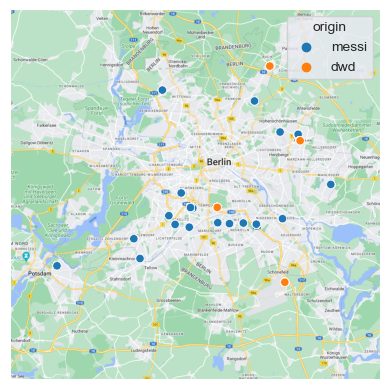

In [10]:
# locations
# https://scitools.org.uk/cartopy/docs/v0.18/cartopy/io/img_tiles.html
# https://docs.dkrz.de/doc/visualization/sw/python/source_code/python-matplotlib-example-high-resolution-background-image-plot.html

trans = ccrs.PlateCarree() # do not change!
request = cimgt.GoogleTiles() # zoom level = 11
#request = cimgt.OSM() # zoom level = 10
#request = cimgt.Stamen(style="watercolor") # zoom level = 10
#extent = [10, 15, 50, 55]  # (xmin, xmax, ymin, ymax)

fig, ax = plt.subplots(subplot_kw={"projection": request.crs})
ax.add_image(request, 11) 
sns.scatterplot(data=tmp_raw, x="lon", y="lat", hue="origin", transform=trans, ax=ax)
#ax.scatter(tmp_raw.lon, tmp_raw.lat, transform=trans) # faster plotting for debugging

fig.savefig("../figs/locations.png", dpi=300, bbox_inches="tight")

## CLUSTER ANALYSIS

### Feature Engineering

Es werden folgende Parameter berechnet:
- $T_{max} - T_{min}$: Maß für die Temperaturschwankung (erwartungsgemäß zwischen Tag und Nacht)
- **Mittlere Abweichung vom Berlin Mittel**: Als Ersatz für die mittlere Temperatur, da die Messwerte einzelner MESSIs systematische Unsicherheiten enthalten könnten.
- **Standardabweichung der mittleren Abweichung**: Maß für die Varianz der Temperatur.
- **Höhe über NN**?

In [11]:
# Warum nicht mittlere Temperatur anstatt mittlere Abweichung?
# Bisher keine Kalibrierung der Messdaten?
# Höhe erstmal weglassen, um zu gucken, ob gefundene Cluster dann mit der Höhe übereinstimmen?

In [12]:
# compute mean temperature of dwd stations for every timestep
dwd_mean = (tmp_raw[tmp_raw.origin == "dwd"]
    .groupby("time_measured", as_index=False)
    ["tmp"].mean()
)
dwd_mean

,time_measured,tmp
0,2022-08-01 00:00:00,21.075000
1,2022-08-01 00:10:00,21.000000
2,2022-08-01 00:20:00,20.825000
3,2022-08-01 00:30:00,20.700000
4,2022-08-01 00:40:00,20.550000
...,...,...
4459,2022-08-31 23:10:00,14.833333
4460,2022-08-31 23:20:00,14.833333
4461,2022-08-31 23:30:00,14.766667
4462,2022-08-31 23:40:00,14.700000


In [13]:
# compute deviation from dwd mean for every messi and time step (merge & subtract)
tmp_dev = (tmp_raw
    [tmp_raw.origin == "messi"]
    .merge(right=dwd_mean, on="time_measured", how="inner", suffixes=(None, "_dwd_mean"))
)
tmp_dev["dev_dwd"] = tmp_dev["tmp"] - tmp_dev["tmp_dwd_mean"]
tmp_dev

,time_measured,id,tmp,lon,lat,alt,origin,station_name,day,tmp_dwd_mean,dev_dwd
0,2022-08-01 00:00:00,2,21.690,13.33395,52.48429,42.0,messi,NaN,1,21.075,0.615
1,2022-08-01 00:00:00,8,21.930,13.47643,52.44803,34.0,messi,NaN,1,21.075,0.855
2,2022-08-01 00:00:00,9,NaN,13.31014,52.45784,72.0,messi,NaN,1,21.075,NaN
3,2022-08-01 00:00:00,13,NaN,13.55526,52.55220,52.0,messi,NaN,1,21.075,NaN
4,2022-08-01 00:00:00,17,22.470,13.52497,52.45489,34.0,messi,NaN,1,21.075,1.395
...,...,...,...,...,...,...,...,...,...,...,...
142843,2022-08-31 23:50:00,74,16.025,13.42531,52.44869,42.0,messi,NaN,31,14.700,1.325
142844,2022-08-31 23:50:00,80,16.260,13.25511,52.40821,40.0,messi,NaN,31,14.700,1.560
142845,2022-08-31 23:50:00,85,NaN,13.31002,52.45791,72.0,messi,NaN,31,14.700,NaN
142846,2022-08-31 23:50:00,88,15.865,13.35114,52.46732,44.0,messi,NaN,31,14.700,1.165


In [14]:
# and start to build data frame with all features ("ftrs") on daily (!) resolution:
# ...

In [15]:
# TODO:
# - Wie könnte man Outlier erkennen? Regression & residuals plotten?
# - Methode mit fehlenden Werten umzugehen: Mindestanzahl an Temperaturwerten pro Tag (!), damit MESSI berücksichtigt wird? Oder Mindestanzahl über den ganzen
# - Messzeitraum?
# - Warum keine Daten vom Wetterturm?
# - Auf den Süden von Berlin konzentrieren, weil dort mehr MESSIs sind?